In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifierCV, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from scipy.fft import fft

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.optimizers import Adam

from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback

import features
import plots

In [50]:
data_folder = 'data/csv/'
data_files = ['10101.smo.csv']

useRaw = False
test_size = 0.3
seed = 13
window_sizes = [2, 5, 10]
days = [0, 1]
cat_matrix = True # True for neural net, any for random forest

In [51]:
df = features.load_features(data_folder, data_files)

for window_size in window_sizes:
    df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.MEAN, features=["EEGv", "EMGv"])
    df = features.features_window(df, window_size=window_size, op=features.WindowOperationFlag.VAR, features=["EEGv", "EMGv"])

df = df.dropna()
df = features.add_times(df)
df = features.filter_days(df, days)

skeep, _ = features.states(useRaw)
print(df[skeep].value_counts())
df

w    23353
n    18231
r     1607
Name: state, dtype: int64


,rawState,state,EEGv,EMGv,temp,bin0,bin1,bin2,bin3,bin4,...,EEGv_mean5,EMGv_mean5,EEGv_var5,EMGv_var5,EEGv_mean10,EMGv_mean10,EEGv_var10,EMGv_var10,time,day
9,w,w,3.906302e-09,1.502535e-09,0.0,1.832130e-07,2.585280e-06,1.207090e-05,4.301820e-06,1.642810e-05,...,3.741155e-09,3.458673e-09,1.498070e-19,2.918457e-18,3.492354e-09,4.028991e-09,1.383278e-19,1.174949e-17,9,0
10,w,w,3.001668e-09,3.135420e-09,0.0,1.103740e-06,9.269060e-06,1.400610e-05,2.049100e-06,2.097150e-07,...,3.542631e-09,3.205920e-09,2.212336e-19,2.643584e-18,3.458235e-09,4.234199e-09,1.613037e-19,1.082733e-17,10,0
11,w,w,3.157240e-09,7.188107e-10,0.0,1.993320e-07,1.150990e-06,1.115200e-07,3.006320e-06,2.646350e-05,...,3.519540e-09,2.170232e-09,2.394823e-19,1.038387e-18,3.460798e-09,3.727737e-09,1.595093e-19,1.164876e-17,11,0
12,w,w,3.232860e-09,1.362585e-09,0.0,6.723340e-06,1.974860e-05,2.114680e-05,3.994050e-05,5.279330e-05,...,3.488647e-09,1.884663e-09,2.544654e-19,1.003362e-18,3.463789e-09,3.683054e-09,1.578852e-19,1.185921e-17,12,0
13,w,w,2.866313e-09,9.224795e-10,0.0,5.459050e-07,1.075420e-05,1.770740e-05,1.950590e-06,1.439120e-07,...,3.232876e-09,1.528366e-09,1.617625e-19,9.083126e-19,3.420904e-09,3.589167e-09,1.923463e-19,1.232743e-17,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,w,w,2.507899e-09,1.838901e-10,0.0,1.743860e-05,1.410460e-05,6.518760e-06,3.496290e-06,1.399800e-06,...,5.153583e-09,6.570637e-11,4.655296e-18,4.401186e-21,5.298721e-09,5.334759e-11,2.296035e-18,2.139153e-21,43195,1
43196,w,w,2.514728e-09,1.684481e-08,0.0,7.653840e-06,5.644110e-07,1.542470e-05,1.270840e-05,7.309980e-06,...,4.159043e-09,3.425411e-09,3.798095e-18,5.627933e-17,5.025476e-09,1.734354e-09,3.073961e-18,2.819046e-17,43196,1
43197,w,w,2.111915e-09,7.823187e-11,0.0,5.181470e-05,2.729230e-05,3.254330e-06,3.029630e-08,3.626520e-08,...,3.134282e-09,3.434402e-09,1.166625e-18,5.620348e-17,4.706193e-09,1.737528e-09,3.895232e-18,2.817865e-17,43197,1
43198,w,w,1.894267e-09,5.085800e-11,0.0,2.056730e-05,1.925550e-06,1.615030e-07,1.966620e-06,7.334930e-06,...,2.733267e-09,3.437653e-09,1.203687e-18,5.617590e-17,4.430645e-09,1.738285e-09,4.689062e-18,2.817581e-17,43198,1


In [52]:
df1 = df.copy()
# drop bin0 to bin400
for i in range(401):
    df1 = df1.drop([f"bin{i}"], axis=1)

df1

,rawState,state,EEGv,EMGv,temp,EEGv_mean2,EMGv_mean2,EEGv_var2,EMGv_var2,EEGv_mean5,EMGv_mean5,EEGv_var5,EMGv_var5,EEGv_mean10,EMGv_mean10,EEGv_var10,EMGv_var10,time,day
9,w,w,3.906302e-09,1.502535e-09,0.0,4.025735e-09,2.103251e-09,2.852822e-20,7.217189e-19,3.741155e-09,3.458673e-09,1.498070e-19,2.918457e-18,3.492354e-09,4.028991e-09,1.383278e-19,1.174949e-17,9,0
10,w,w,3.001668e-09,3.135420e-09,0.0,3.453985e-09,2.318977e-09,4.091821e-19,1.333156e-18,3.542631e-09,3.205920e-09,2.212336e-19,2.643584e-18,3.458235e-09,4.234199e-09,1.613037e-19,1.082733e-17,10,0
11,w,w,3.157240e-09,7.188107e-10,0.0,3.079454e-09,1.927115e-09,1.210139e-20,2.919999e-18,3.519540e-09,2.170232e-09,2.394823e-19,1.038387e-18,3.460798e-09,3.727737e-09,1.595093e-19,1.164876e-17,11,0
12,w,w,3.232860e-09,1.362585e-09,0.0,3.195050e-09,1.040698e-09,2.859192e-21,2.072228e-19,3.488647e-09,1.884663e-09,2.544654e-19,1.003362e-18,3.463789e-09,3.683054e-09,1.578852e-19,1.185921e-17,12,0
13,w,w,2.866313e-09,9.224795e-10,0.0,3.049586e-09,1.142532e-09,6.717853e-20,9.684656e-20,3.232876e-09,1.528366e-09,1.617625e-19,9.083126e-19,3.420904e-09,3.589167e-09,1.923463e-19,1.232743e-17,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43195,w,w,2.507899e-09,1.838901e-10,0.0,3.572712e-09,1.071859e-10,2.267653e-18,1.176709e-20,5.153583e-09,6.570637e-11,4.655296e-18,4.401186e-21,5.298721e-09,5.334759e-11,2.296035e-18,2.139153e-21,43195,1
43196,w,w,2.514728e-09,1.684481e-08,0.0,2.511313e-09,8.514348e-09,2.331421e-23,1.387930e-16,4.159043e-09,3.425411e-09,3.798095e-18,5.627933e-17,5.025476e-09,1.734354e-09,3.073961e-18,2.819046e-17,43196,1
43197,w,w,2.111915e-09,7.823187e-11,0.0,2.313321e-09,8.461518e-09,8.112896e-20,1.405590e-16,3.134282e-09,3.434402e-09,1.166625e-18,5.620348e-17,4.706193e-09,1.737528e-09,3.895232e-18,2.817865e-17,43197,1
43198,w,w,1.894267e-09,5.085800e-11,0.0,2.003091e-09,6.454494e-11,2.368524e-20,3.746644e-22,2.733267e-09,3.437653e-09,1.203687e-18,5.617590e-17,4.430645e-09,1.738285e-09,4.689062e-18,2.817581e-17,43198,1


In [53]:
x_train, x_test, y_train, y_test, le = features.split_data(df1, useRaw, test_size, seed, cat_matrix)

# Random Forest

[[5362   21  141]
 [  98  337   28]
 [ 181   32 6758]]
              precision    recall  f1-score   support

           n       0.95      0.97      0.96      5524
           r       0.86      0.73      0.79       463
           w       0.98      0.97      0.97      6971

    accuracy                           0.96     12958
   macro avg       0.93      0.89      0.91     12958
weighted avg       0.96      0.96      0.96     12958



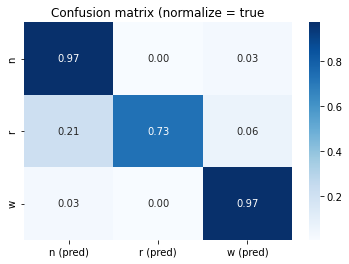

"Score": 0.9569377990430622


In [54]:
rfc = RandomForestClassifier(random_state=seed)
rfc.fit(x_train, y_train)
y_predict = rfc.predict(x_test)

plots.plot_confusion(model=rfc, x_test=x_test, y_test=y_test, le=le, cat_matrix=cat_matrix, normalize='true')
print(f'\"Score\": {rfc.score(x_test, y_test)}')

# Neural Network

In [ ]:
def baseline_model(input_dim, num_classes, lr=0.001):
    model = Sequential()
    model.add(Dense(16, input_dim=input_dim, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr), metrics=['accuracy'])

    return model

model = baseline_model(x_train.shape[1], le.classes_.size)
model.summary()

In [ ]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_test, y_test),
                    epochs=25,
                    batch_size=10,
                    verbose=0,
                    callbacks=[TqdmCallback(verbose=1)]
                )

plots.plot_loss(history.history)

In [ ]:
plots.plot_confusion(model=model, x_test=x_test, y_test=y_test, le=le, cat_matrix=True, normalize='true')